<a href="https://colab.research.google.com/github/sarmientoj24/EE298/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from keras.layers import Lambda, Input, Dense, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Activation, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.models import load_model

import numpy as nps
import matplotlib.pyplot as plt
import os
# Main cell to run
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Implement VAE here

class VAE():
  image_shape = (80, 60, 3)

  def __init__(self, load=False, encoder_h5=None, 
               decoder_h5=None):
    # Build encoder
    # Adopted from https://github.com/YongWookHa/VAE-Keras/blob/master/VAE.py

    if load:
      print("Loading model from h5...")
      self.load_model(encoder_h5, layer_ = 'encoder')
      self.load_model(decoder_h5, layer_ = 'decoder')

    else:
      print("Creating model architecture...")
      # self.encoder_inputs = Input(shape=self.image_shape)
      # filter_dim = 128
      # x = self.encoder_inputs
      # x = Conv2D(int(filter_dim/16), kernel_size=(2,2), strides=(2,2), padding='SAME')(x)
      # x = BatchNormalization()(x)
      # x = LeakyReLU(0.2)(x)
      # x = Conv2D(int(filter_dim/8), kernel_size=(2,2), strides=(2,2), padding='SAME')(x)
      # x = BatchNormalization()(x)
      # x = LeakyReLU(0.2)(x)
      # x = Conv2D(int(filter_dim/4), kernel_size=(2,2), strides=(2,2), padding='SAME')(x)
      # x = BatchNormalization()(x)
      # x = LeakyReLU(0.2)(x)
      # x = Conv2D(int(filter_dim/2), kernel_size=(2,2), strides=(2,2), padding='SAME')(x)
      # x = BatchNormalization()(x)
      # x = LeakyReLU(0.2)(x)
      # x = Conv2D(filter_dim, kernel_size=(2,2), strides=(2,2), padding='SAME')(x)
      # x = BatchNormalization()(x)
      # x = LeakyReLU(0.2)(x)
      # # x = GlobalAveragePooling2D()(x)

      # enc_shape = K.int_shape(x)
      # print(enc_shape)
      # # generate latent vector Q(z|X)
      # x = Flatten()(x)
      # x = Dense(64)(x)
      # x = LeakyReLU(0.2)(x)
      # z_mean = Dense(z_dim, name='z_mean')(x)
      # z_log_sigma = Dense(z_dim, name='z_log_sigma')(x)

      # # use reparameterization trick to push the sampling out as input
      # # note that "output_shape" isn't necessary with the TensorFlow backend
      # z = Lambda(self.sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_sigma])

      # # instantiate encoder model
      # self.encoder = Model(self.encoder_inputs, [z_mean, z_log_sigma, z], name='encoder')
      # self.encoder.summary()
      # plot_model(self.encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

      # # Decoder
      # self.latent_inputs = Input(shape=(z_dim,), name='z_sampling')
      # z = Dense(enc_shape[1] * enc_shape[2] * enc_shape[3], activation='relu')(self.latent_inputs)
      # z = Reshape((enc_shape[1], enc_shape[2], enc_shape[3]))(z)
      # z = Conv2DTranspose(int(filter_dim/2), kernel_size=(1, 2), strides=(2,1), padding='same')(z)
      # z = BatchNormalization()(z)
      # z = Activation('relu')(z)
      # z = Conv2DTranspose(int(filter_dim/4), kernel_size=(2,2), strides=(2,2), padding='same')(z)
      # z = BatchNormalization()(z)
      # z = Activation('relu')(z)
      # z = Conv2DTranspose(int(filter_dim/8), kernel_size=(2,1), strides=(2,2), padding='same')(z)
      # z = BatchNormalization()(z)
      # z = Activation('relu')(z)
      # z = Conv2DTranspose(int(filter_dim/16), kernel_size=(2,2), strides=(2,2), padding='same')(z)
      # z = BatchNormalization()(z)
      # z = Activation('relu')(z)
      # z = Conv2DTranspose(3, kernel_size=(2,2), strides=(2,2), padding='same')(z)
      # decoder_output = Activation('tanh')(z)

      # # instantiate decoder model
      # self.decoder = Model(self.latent_inputs, decoder_output, name='decoder')
      # self.decoder.summary()
      # plot_model(self.decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

      # # instantiate VAE model
      # outputs = self.decoder(self.encoder(self.encoder_inputs)[2])
      # self.vae = Model(self.encoder_inputs, outputs, name='vae')
      # self.vae.summary()

      #### Meryl Version modified
      z_dim = 10
      kernel_size = 2
      latent_dim = 10
      filter_dims = [8, 16, 32]
      filter_decoder = [32, 16, 8]
      
      self.inputs = Input(shape=self.image_shape, name='encoder_input')
      x = self.inputs
      for i in range(2):
        filters = filter_dims[i]
        x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=2,
                  padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

      # shape info needed to build decoder model
      shape = K.int_shape(x)

      # generate latent vector Q(z|X)
      x = Flatten()(x)
      x = Dense(64, activation='relu')(x)
      z_mean = Dense(latent_dim, name='z_mean')(x)
      z_log_sigma = Dense(latent_dim, name='z_log_sigma')(x)

      # use reparameterization trick to push the sampling out as input
      # note that "output_shape" isn't necessary with the TensorFlow backend
      z = Lambda(self.sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_sigma])

      # instantiate encoder model
      self.encoder = Model(self.inputs, [z_mean, z_log_sigma, z], name='encoder')
      self.encoder.summary()
      plot_model(self.encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

      # build decoder model
      self.latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
      x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(self.latent_inputs)
      x = Reshape((shape[1], shape[2], shape[3]))(x)

      for i in range(2):
        filters = filter_decoder[i]
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=2,
                            padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

      outputs = Conv2DTranspose(filters=3,
                                kernel_size=kernel_size,
                                activation='tanh',      # Changed to tanh because data preparation was geared to be [-1, 1]
                                padding='same',
                                name='decoder_output')(x)

      # instantiate decoder model
      self.decoder = Model(self.latent_inputs, outputs, name='decoder')
      self.decoder.summary()
      plot_model(self.decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

      # instantiate VAE model
      outputs = self.decoder(self.encoder(self.inputs)[2])
      self.vae = Model(self.inputs, outputs, name='vae')
      self.vae.summary()

      # Construct the Loss function
      # VAE loss = mse_loss or xent_loss + kl_loss

      reconstruction_loss = mse(K.flatten(self.inputs), K.flatten(outputs))
      # #reconstruction_loss = binary_crossentropy(K.flatten(self.encoder_inputs),
      # #                                           K.flatten(outputs))

      reconstruction_loss *= self.image_shape[0] * self.image_shape[1] * self.image_shape[2]
      kl_loss = 1 + (z_log_sigma ** 2) - K.square(z_mean) - K.exp(z_log_sigma ** 2)
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      vae_loss = K.mean(reconstruction_loss + kl_loss)
      # recon = K.sum(K.binary_crossentropy(K.flatten(outputs), K.flatten(self.encoder_inputs)), axis=1)
      # kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
      # vae_loss = recon + kl
      self.vae.add_loss(vae_loss)
      # self.vae.metrics_tensors.append(reconstruction_loss)
      # self.vae.metrics_names.append("val_loss")
      self.vae.compile(optimizer='adam')

  def get_summary(layer_='vae'):
    if layer_ == 'vae':
      self.vae.summary()

    elif layer == 'decoder':
      self.decoder.summary()

    else:
      self.encoder.summary()
  
  def load_model(self, h5_file, layer_):
    print("Loading h5 ", layer_)
    if layer_ == 'encoder':
      self.encoder = load_model(h5_file)
    else:
      self.decoder = load_model(h5_file)

  def _fit(self, epochs, batch_size, x_train):
    self.history = self.vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1)
    self.vae.save('vae_mnist.h5')
    self.encoder.save('vae_encoder.h5')
    self.decoder.save('vae_decoder.h5')

  def get_history(self):
    return self.history
  
  def plot_loss_function(self):
    # Plot training & validation loss values
    plt.plot(self.history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

  def get_encoder_model(self):
    return self.encoder
  
  def get_decoder_model(self):
    return self.decoder
  
  def get_vae_model(self):
    return self.vae
  
  # Sampling to be used in training
  def sampling(self, args):
    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_sigma / 2) * epsilon
    # return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [0]:
# ImageEncoder
# After training VAE, create a new model based of the trained encoder
# for encoding the image samples
class ImageEncoder():
  input_shape = (80, 60, 3)

  def __init__(self, encoder, z_dim=10):
    self.encoder = Model(
        Input(shape=input_shape),
        encoder)
    self.epsilon = K.random_normal(shape=(z_dim, ))
  
  def _encode_sampled(self, input_image):
    z_mean, z_log_sigma, z = self.encoder.predict(input_image)
    # We only need z_mean and z_log_sigma
    return z_mean + K.exp(z_log_sigma / 2) * epsilon
    # return z_mean + K.exp(0.5 * z_log_var) * epsilon
  
  def _encode(self, input_image):
    z_mean, z_log_sigma, z = self.encoder.predict(input_image)
    return z_mean, z_log_sigma

In [0]:
#### HELPER FUNCTIONS
import cv2
import glob, os
import pandas as pd
from PIL import Image
import numpy as np

import imageio
def read_imgs_to_np_from_folder(img_folder):
  cwd = os.getcwd()

  # os.chdir(img_folder + '/')

  imgs = glob.glob(img_folder + '*.jpg')
  # height,width = imageio.imread(imgs[0]).shape[:2]

  X = []
  count = 0
  for f in imgs:
    x = imageio.imread(f)

    if len(x.shape) == 3 and x.shape[0] == 80 and x.shape[1] == 60 and x.shape[2] == 3:
      x = x.astype(np.float32) / 255.0
      X.append(x)
      count += 1
    if count % 10000 == 0:
      print("Traversed ", count)
    
  X = np.array(X)
  print(X.shape)
  return X

##### This function should be in the web-app (REMOVE once completed) ###########
import math
import numpy as np
import operator
# import pandas as pd

# decoder_loaded_model = load_model('decoder.h5')

def compute_log_likelihood(z_gen, mu_, log_sigma):
  # (zi−μi(x))22σi(x)2
  # Adopted here https://datascience.stackexchange.com/questions/64097/how-to-use-variational-autoencoders-%CE%BC-and-%CF%83-with-user-generated-z/64163#64163
  term_a = (z_gen - mu_) ** 2
  term_b = 2 * (log_sigma ** 2)
  term_c = -1 * (term_a / term_b)

  # −log(2π−−√σi(x))
  term_d = np.log(((2 * np.pi) ** 0.5) * (log_sigma))
  term_e = term_c - term_d

  likelihood = np.sum(term_e)
  return likelihood

def find_nearest(z_var_generated):
  # SQL Query get all of those needed and store to dataframe
  # Do Query here
  z_dim = len(z_var_generated)
  z_var_generated = np.array(z_var_generated) # Convert to numpy

  ids_ = sql_df['id'].to_list()
  df = sql_df[['mu_1', 'mu_2', 'mu_3', 'mu_4', 'mu_5', 
               'mu_6', 'mu_7', 'mu_8', 'mu_9', 'mu_10',
               'log_sigma_1', 'log_sigma_2', 'log_sigma_3', 'log_sigma_4', 'log_sigma_5',
               'log_sigma_6', 'log_sigma_7', 'log_sigma_8', 'log_sigma_9', 'log_sigma_10']]
  
  datapoints_encoded_in_db = df.to_numpy()
  rows = datapoints_encoded_in_db.shape[1]

  likelihoods = {}

  counter = 0
  for data in rows:
    mu_vector = data[:z_dim]
    sigma_vector = data[z_dim:z_dim*2]
    log_likelihood = compute_log_likelihood(z_var_generated,
                                            mu_vector, log_sigma_vector)
    likelihoods[id_s[counter]] = log_likelihood
    counter += 1

  # Sort dictionary by likelihood
  sorted_x = sorted(likelihoods.items(), key=operator.itemgetter(1))

  # return top three descending
  return sorted_x[0], sorted_x[1], sorted_x[2]

def decode_img(z_var_generated):
  img = decoder_loaded_model.predict(z_var_generated)
  return img

##########Functions above are to be used inside the web-app locally hosted #########3

# Function to use ENCODER and ENCODE datapoints to database
# Could be run on Colab or PC with GPU/Keras
import sqlite3
def encode_img_from_folder_to_db(folder, db, encoder):
  try:
    conn = sqlite3.connect(db)
  except Error as e:
    print(e)

  conn = self.create_connection(database)

  sql = '''
          SELECT id, image_id
          FROM appchemy_apparel_dummy
        '''

  products_df = pd.read_sql_query(sql, conn)
  image_ids = products_df['image_id'].to_list()

  cwd = os.getcwd()
  img_folder = folder + '/'

  cur = conn.cursor()
  os.chdir(img_folder)

  for index, image_id in enumerate(image_ids):
    img_name = str(image_id) + '.jpg'
    
    try:
        img = cv2.imread(img_name, mode='RGB')
        if img.shape() == (80, 60, 3):
          mu_, log_sigma_ = encoder.__encode(img)      # change if either to store z or mu and log_var

          # Update in db
          sql = '''
                UPDATE appchemy_apparel_dummy SET
                mu_1 = {}, mu_2 = {}, mu_3 = {}, mu_4 = {}, mu_5 = {}, 
                mu_6 = {}, mu_7 = {}, mu_8 = {}, mu_9 = {}, mu_10 = {},
                log_sigma_1 = {}, log_sigma_2 = {}, log_sigma_3 = {}, 
                log_sigma_4 = {}, log_sigma_5 = {}, log_sigma_6 = {}, 
                log_sigma_7 = {}, log_sigma_8 = {}, log_sigma_9 = {}, log_sigma_10 = {}
                WHERE id = {}
              '''.format(mu_[0], mu_[1], mu_[2], mu_[3], mu_[4], mu_[5], 
                         mu_[6], mu_[7], mu_[8], mu_[9], 
                         log_sigma_[0], log_sigma_[1], log_sigma_[2], log_sigma_[3], log_sigma_[4], 
                         log_sigma_[5], log_sigma_[6], log_sigma_[7], log_sigma_[8], log_sigma_[9],
                         image_id)
          cur.execute(sql)
          if index % 200 == 0:
            conn.commit()
          print("File not 80x60x3: ", img_name)
    except:
      print("Error reading file: ", img_name)
      continue

  conn.commit()
  conn.close()


In [0]:
!chmod 600 '/content/drive/My Drive/ee298/dataset.tar.xz'
!cp '/content/drive/My Drive/ee298/dataset.tar.xz' '/content/data_im/'

In [0]:
!tar -xf '/content/data_im/dataset.tar.xz'

In [11]:
x_train = read_imgs_to_np_from_folder('/content/apparel_reduced/')

Traversed  10000
Traversed  20000
Traversed  30000
Traversed  40000
Traversed  50000
Traversed  60000
Traversed  70000
Traversed  80000
Traversed  90000
(92013, 80, 60, 3)


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 80, 60, 3)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 40, 30, 16)   208         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 40, 30, 16)   64          conv2d_11[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 40, 30, 16)   0           batch_normalization_21[0][0]     
____________________________________________________________________________________________

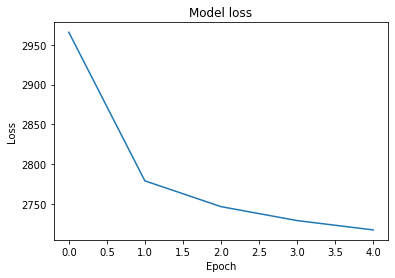

In [20]:
def sampling(args):
    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_sigma / 2) * epsilon

z_dim = 20
kernel_size = 2
latent_dim = 20
filter_dims = [16, 32, 64]
filter_decoder = [64, 32, 16]
image_shape = (80, 60, 3)
epochs = 5
batch_size=32
from keras import layers, initializers
from keras.callbacks import EarlyStopping

inputs = Input(shape=image_shape, name='encoder_input')
x = inputs
for i in range(2):
  filters = filter_dims[i]
  x = Conv2D(filters=filters,
            kernel_size=kernel_size,
            strides=2,
            padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_sigma = Dense(latent_dim, name='z_log_sigma',
      kernel_initializer='random_uniform',
      bias_initializer=initializers.Constant(0.1))(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_sigma])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(64, activation='relu')(latent_inputs)
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
  filters = filter_decoder[i]
  x = Conv2DTranspose(filters=filters,
                      kernel_size=kernel_size,
                      strides=2,
                      padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

# Construct the Loss function
# VAE loss = mse_loss or xent_loss + kl_loss

# reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                           K.flatten(outputs))

reconstruction_loss *= image_shape[0] * image_shape[1] * image_shape[2]
# reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + (z_log_sigma) - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

# recon = K.sum(K.binary_crossentropy(K.flatten(inputs), K.flatten(outputs)))
# kl = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=1)
# vae_loss = recon + kl

# vae.metrics_tensors.append(reconstruction_loss)
# vae.metrics_names.append("val_loss")

# translate our loss into Keras code
# def vae_loss(y_true, y_pred):
#     """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
#     recon = K.sum(K.binary_crossentropy(y_true, y_pred))
#     kl = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=1)
#     return recon + kl
vae.add_loss(vae_loss)
es = EarlyStopping(monitor='vae_loss', mode='min', verbose=1, patience=20)
vae.compile(optimizer='adam')

history = vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1)
vae.save('vae_mnist2.h5')
encoder.save('vae_encoder2.h5')
decoder.save('vae_decoder2.h5')

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# plt.plot(history.history['accuracy'])
# plt.title('Model Acc')
# plt.ylabel('Acc')
# plt.xlabel('Epoch')
# plt.show()

/content/apparel_reduced/70666.jpg
(80, 60, 3)


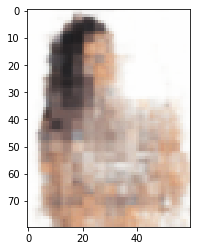

In [22]:
imgs = glob.glob('/content/apparel_reduced/' + '*.jpg')
img_1 = imgs[0]
print(img_1)
x = imageio.imread(img_1)
x = x.astype(np.float32) / 255.0
x = np.reshape(x, [-1, 80, 60, 3])
print(x[0].shape)
out_vae = vae.predict(x)
plt.imshow(out_vae[0])

(80, 60, 3)


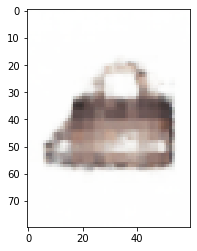

In [23]:
img_1 = imgs[100]
x = imageio.imread(img_1)
x = x.astype(np.float32) / 255.0
x = np.reshape(x, [-1, 80, 60, 3])
print(x[0].shape)
out_vae = vae.predict(x)
plt.imshow(out_vae[0])

(80, 60, 3)


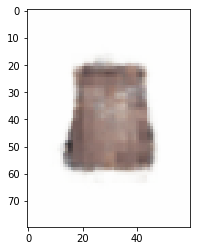

In [24]:
img_1 = imgs[1000]
x = imageio.imread(img_1)
x = x.astype(np.float32) / 255.0
x = np.reshape(x, [-1, 80, 60, 3])
print(x[0].shape)
out_vae = vae.predict(x)
plt.imshow(out_vae[0])

In [27]:
z_fake = np.random.normal(size=(20,))
print(z_fake.shape)
print(z_fake.reshape(-1, 10))

(20,)
[[-0.73064007  0.77401613  1.67968952 -1.54001122  0.93687507 -1.34876598
  -0.14189822 -0.27654709  0.6168042  -0.21228212]
 [ 0.55304146 -0.92944905  0.16454563 -0.05684331  0.50134312  0.24166479
   1.37686977  1.48445735 -0.9749833   0.33519895]]


In [0]:
fake_predicted = decoder.predict(z_fake.reshape(-1, 20))

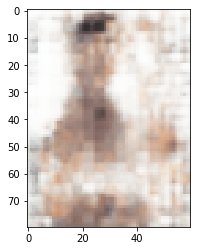

In [29]:
plt.imshow(fake_predicted[0])